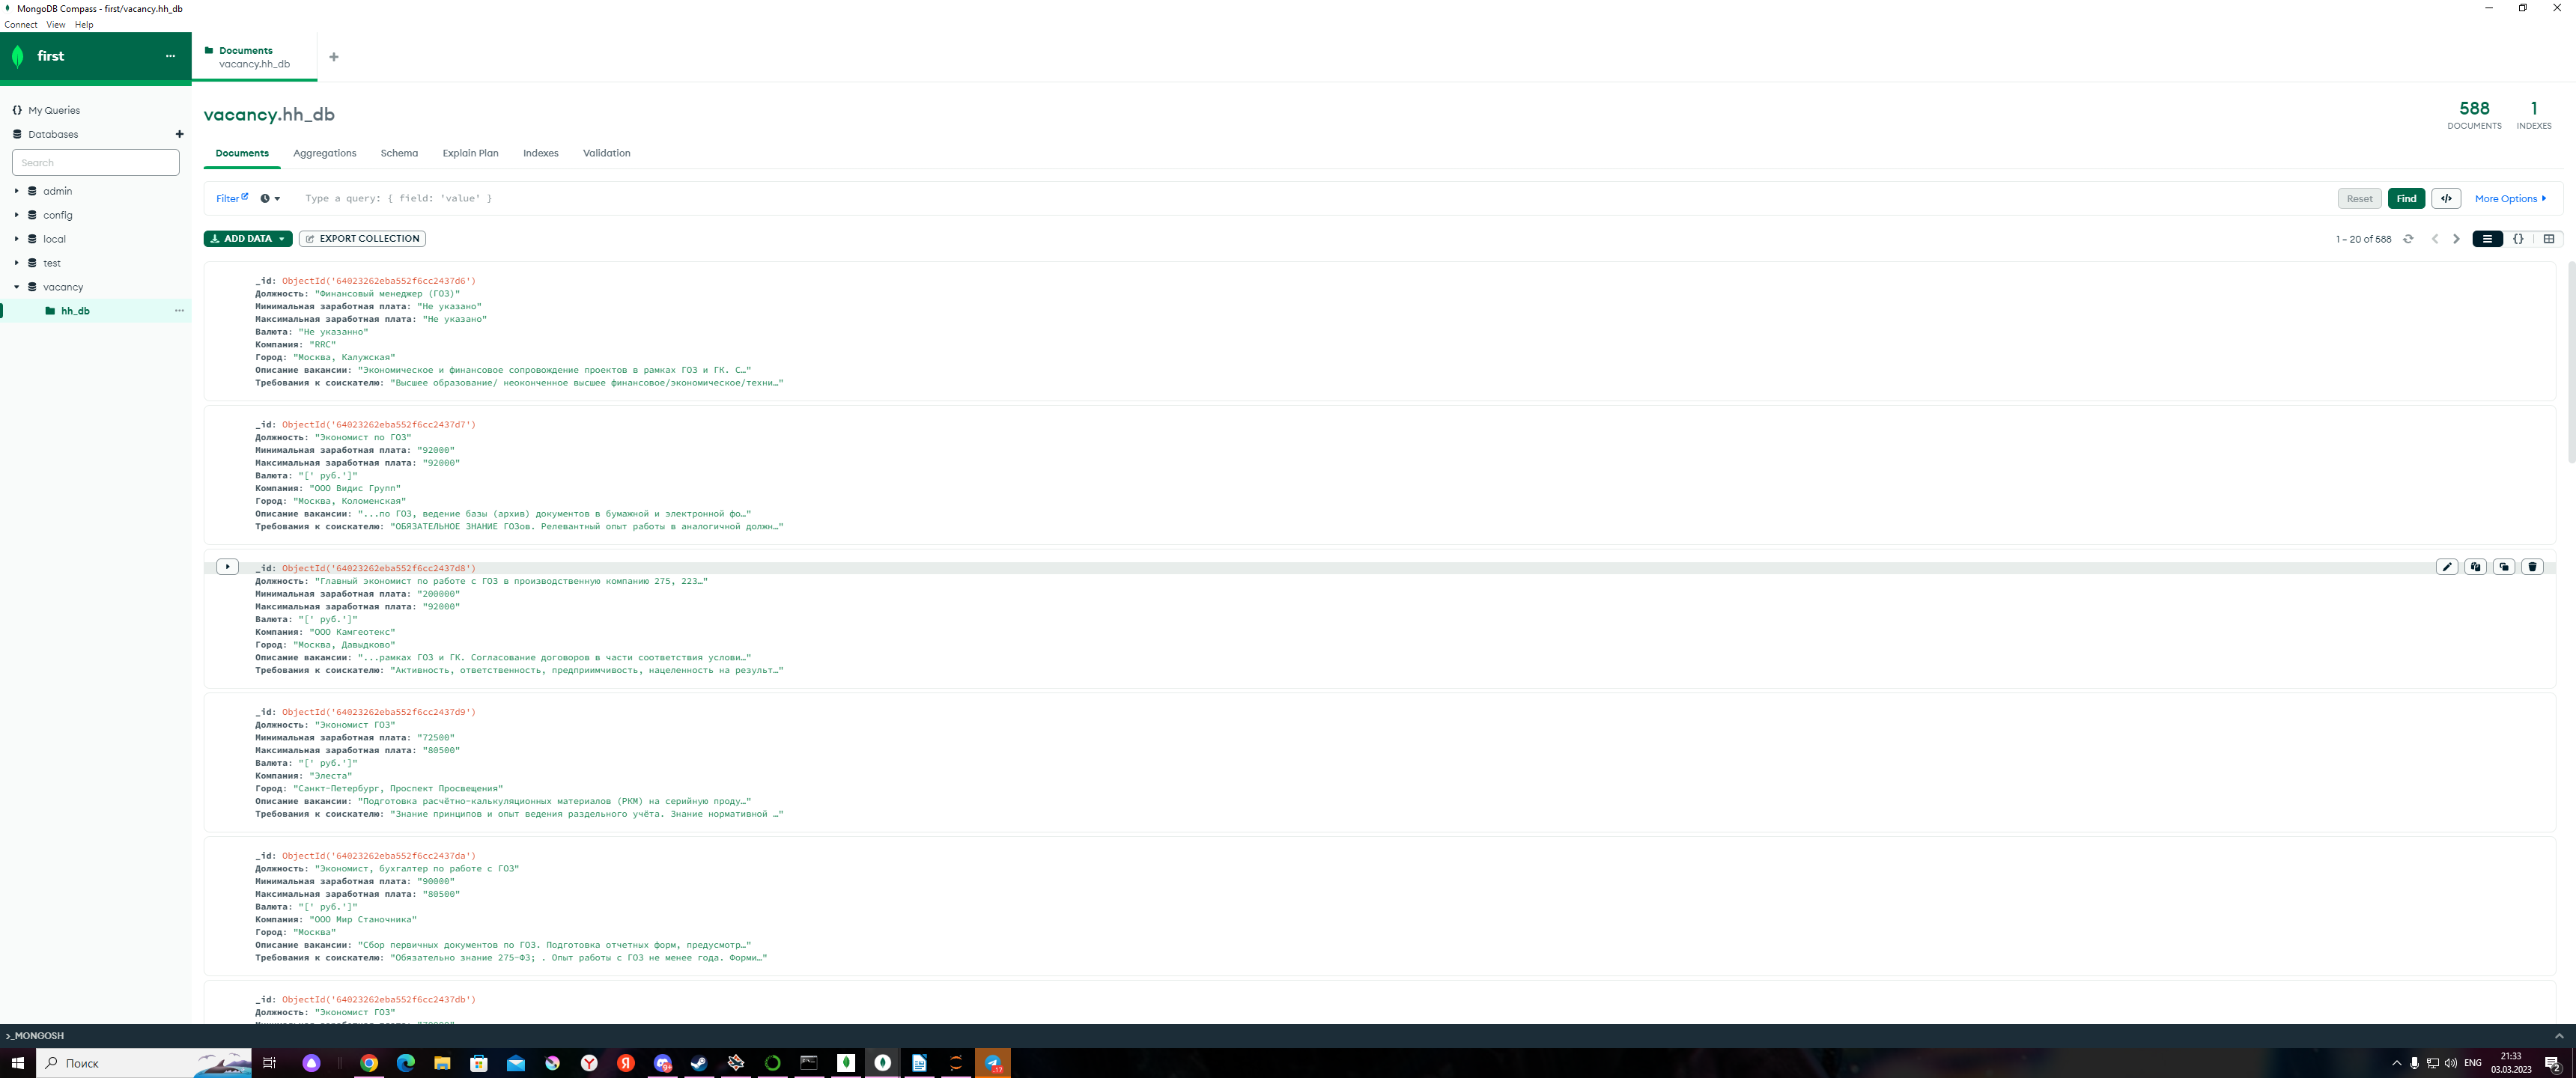

1. Развернуть у себя на компьютере/виртуальной машине/хостинге MongoDB и реализовать функцию, которая будет добавлять только новые вакансии/продукты в вашу базу.

In [35]:
# Импортируем нужные для работы библиотеки и функции:

from bs4 import BeautifulSoup
import requests
import re
import time
from re import sub
from decimal import Decimal
import io
from datetime import datetime
from pymongo import MongoClient
import json
import warnings
warnings.filterwarnings('ignore')

from pprint import pprint 
from pymongo.errors import DuplicateKeyError

In [36]:
client = MongoClient('mongodb://localhost:27017/')

In [37]:
print(client.list_database_names()) 

['admin', 'config', 'local', 'test', 'vacancy']


In [41]:
db = client.vacancy

In [46]:
# Основа для предстоящей работы: основная ссылка и юзер-агент, чтобы не заблочили. 
# Пользовательский ввод:
user_requests = input('Введите запрос: ').strip() # Мой запрос Python
total_pages = int(input('Введите колличество страниц для сбора данных: ')) # Запрашиваю 40 стр.

url = 'https://moscow.hh.ru/search/vacancy?text=' + user_requests+ '&salary=&ored_clusters=true&enable_snippets=true&page=0'

headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)\
    Chrome/110.0.0.0 Safari/537.36',}

map = {} # Создаю пустой словарь и счетчик 
id = 0 

start = time.time() # Функция для оценки времени

pause = time.sleep(5) # Функция для пауз

# Цикл для скрейпинга страниц
for page in range(total_pages):
    
    request_start_page = url + str(page)

    print("Scraping page: %d" % (page +1))

    # Мой основной запрос на скрейпинг всей страницы:
    my_requests = requests.get(request_start_page, headers=headers).text
    soup = BeautifulSoup(my_requests, 'html.parser')
    pause
    job_vacancy = soup.find_all("div", {"class": "vacancy-serp-item__layout"}) 
    
    print(len(job_vacancy))
    
     # Предохранитель(если что то не так с запросом, чтобы не случился "вечный двигатель"):

    page_nav = soup.find_all('a', {"class": "bloko-button"})

    if(len(page_nav) == 0):
        print("max page number: %d" % (page))
        end = time.time()
        print(end - start)
        break

    for vacancy in range(len(job_vacancy)):
        
        job = job_vacancy[vacancy]
        
        id += 1
        map[id] = {}
        
        # Сайт
        website = 'https://hh.ru/'

        #  Должность
        job_title_and_link = job.find('a', {"class": "serp-item__title"})
        
        #  Ссылка
        job_link = job_title_and_link['href']
        

        # Зарплата (обрабатываем пропуски, через регулярные выражения обрабатываем формат и тут же разносим данные по разным колонкам)
        if job.find('span', {"class": "bloko-header-section-3"}) is None:
            
            min_salary = 0 # 0 = "не указана", что бы была возможность записать эту колонку int
            max_salary = 0 # 0 = "не указана", что бы была возможность записать эту колонку int
            currency = 'Не указанно'
        else:
            salary = job.find('span', {"class": "bloko-header-section-3"}).text
            money = re.findall('[0-9]+\s?[0-9]+\s?[0-9]+', salary)
            currency = str(re.findall('\D+[^о]$', salary))
            for i in range(len(money)):
                if i == 0 :
                    min_salary = str(money[i]).replace('\u202f', '')
                elif i == 1:
                    max_salary = str(money[i]).replace('\u202f', '')
                    


        # Компания
        if job.find('a', {"class": "bloko-link bloko-link_kind-tertiary"}) is None:
            company = "Компания не указанна"
        else:
            company = job.find('a', {"class": "bloko-link bloko-link_kind-tertiary"}).text

        # Город
        if job.find('div',{"data-qa": "vacancy-serp__vacancy-address", "class": "bloko-text"}) is None:
            city = "Город не указанн"
        else:
            city = job.find('div',{"data-qa": "vacancy-serp__vacancy-address", "class": "bloko-text"}).text
        #city = job.find('div',{"data-qa": "vacancy-serp__vacancy-address", "class": "bloko-text"}).text
        
        # Описание вакансии(сразу обрабатываем возможные пропуски)
        if job.find('div', {"data-qa": "vacancy-serp__vacancy_snippet_responsibility", "class": "bloko-text"}) is None:
            vacancy_description = "Описание отсутствует"
        else:
            vacancy_description = job.find('div', {"data-qa": "vacancy-serp__vacancy_snippet_responsibility", "class": "bloko-text"}).text
        
        #Требования к соискателю (сразу обрабатываем возможные пропуски)
        if job.find('div', {"data-qa": "vacancy-serp__vacancy_snippet_requirement", "class": "bloko-text"}) is None:
            requirements_for_the_applicant = "Требования к соискателю не указанны"
        else:
            requirements_for_the_applicant = job.find('div', {"data-qa": "vacancy-serp__vacancy_snippet_requirement", "class": "bloko-text"}).text
        
        #Записываем все найденное в словарь:
        
        map[id]["Сайт"] = str(website)
        map[id]["Должность"] = str(job_title_and_link)
        map[id]["Ссылка"] = str(job_link)
        map[id]["Минимальная заработная плата"] = int(min_salary)
        map[id]["Максимальная заработная плата"] = int(max_salary)
        map[id]["Валюта"] = str(currency)
        map[id]["Компания"] = str(company)
        map[id]["Город"] = str(city)
        map[id]["Описание вакансии"] = str(vacancy_description)
        map[id]["Требования к соискателю"] = str(requirements_for_the_applicant)
        
        if not len(list(db.hh_db.find({"Ссылка": job_link}))):
            db.hh_db.insert_one(map[id])
        else:
            print(f'Эта вакансия уже есть в базе данных!\n{map[id]}')
        
print(map)

Введите запрос: ГОЗ
Введите колличество страниц для сбора данных: 10
Scraping page: 1
20
Scraping page: 2
20
Scraping page: 3
20
Scraping page: 4
20
Scraping page: 5
20
Эта вакансия уже есть в базе данных!
{'Сайт': 'https://hh.ru/', 'Должность': '<a class="serp-item__title" data-qa="serp-item__title" href="https://balashikha.hh.ru/vacancy/71569775?from=vacancy_search_list&amp;query=%D0%93%D0%9E%D0%97" target="_blank">Экономист планово-экономического отдела</a>', 'Ссылка': 'https://balashikha.hh.ru/vacancy/71569775?from=vacancy_search_list&query=%D0%93%D0%9E%D0%97', 'Минимальная заработная плата': 45000, 'Максимальная заработная плата': 0, 'Валюта': "[' руб.']", 'Компания': 'АО ПКО Теплообменник', 'Город': 'Нижний Новгород, Пролетарская', 'Описание вакансии': 'Составление отчетной калькуляции. Составление РКМ по ГОЗ, в т.ч. в соответствие с приказом ФАС 1138 согласование сведений с Заказчиком. ', 'Требования к соискателю': 'Образование высшее (экономическое). Знание основ формирования с

2. Написать функцию, которая производит поиск и выводит на экран вакансии с заработной платой больше введённой суммы (необходимо анализировать оба поля зарплаты). Запрос зп 100 000 руб

In [48]:
for document in db.hh_db.find({'Минимальная заработная плата': {'$gt': 100000},
                           'Максимальная заработная плата': {'$gt': 100000},
                           'Валюта': "[' руб.']"}):
    pprint(document)

{'_id': ObjectId('64023c03eba552f6cc2439c8'),
 'Валюта': "[' руб.']",
 'Город': 'Москва',
 'Должность': '<a class="serp-item__title" data-qa="serp-item__title" '
              'href="https://balashikha.hh.ru/vacancy/77213171?from=vacancy_search_list&amp;query=%D0%93%D0%9E%D0%97" '
              'target="_blank">Ведущий экономист по планированию (п.0184)</a>',
 'Компания': 'ФГУП Всероссийский научно-исследовательский институт автоматики '
             'им. Н.Л. Духова ( ГК Росатом)',
 'Максимальная заработная плата': 130000,
 'Минимальная заработная плата': 130000,
 'Описание вакансии': 'Подготовка расчетно - калькуляционных материалов (РКМ) '
                      'по утвержденным формам согласно постановлению '
                      'Правительства  1465 от 02.12.2017 и Приказа ФАС  '
                      '1138...',
 'Сайт': 'https://hh.ru/',
 'Ссылка': 'https://balashikha.hh.ru/vacancy/77213171?from=vacancy_search_list&query=%D0%93%D0%9E%D0%97',
 'Требования к соискателю': 'Знание но